# Tarea 12
## Análisis de datos
### Ana Isabel Moreno Hernández
---------------------------------------------------------

**Descargamos librerías**

In [4]:
import scipy.optimize as op
    import numpy as np
    import matplotlib.pyplot as plt
    import math
    import random

**Descargamos los datos de ejercicios anteriores:**

In [6]:
file = np.load('fit_ejercise.npy')

In [8]:
x = file[0] # Guardamos las columnas en x, y y yerror
y = file[1]
yerror = file[2]

data = file

**Graficamos los datos para observar qué distribución tiene**

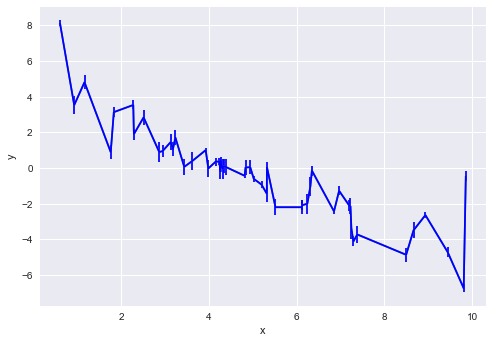

In [9]:
plt.style.use('seaborn')
plt.plot(x, y)
plt.errorbar(x, y,yerr = yerror, markersize = 0.5, fmt = 'blue')
plt.xlabel('x')
plt.ylabel('y')
plt.grid('True')

**Tenemos dos formas de ajustar estos datos. La primera es considerando sólo dos parámetros y la segunda con tres parámetros.**

---------------------

### **Ajuste con dos parámetros**

Primero definimos nuestro modelo y obtenemos $\chi^2 = \sum (y_i - y_m)^2/\Delta y_i$.

In [19]:
def line(m, b,x):
    return m*x + b # Linea recta

def chisq(theta, data):
    m = theta[0] # Primer parámetro
    b = theta[1] # Segundo parámetro
    model = line(m,b,data[0])
    sigma2 = (data[2]**2)
    chisq = (data[1]-model)**2/sigma2 + np.log(sigma2) # Función chi_square
    return chisq.sum()

Observamos si funciona:

In [26]:
chisq([-1,4], data)

1767.8645876493822

Utilizamos minimize para encontrar los parámetros que mejor ajustan nuestros datos a una línea recta. Minimize es de la librería scipy.

In [29]:
ini_point = (-2,4) # Punto inicial para empezar a encontrar los parámetros que mejor se ajustan a los datos.

min_sol = op.minimize(chisq, ini_point, args = data, method = 'L-BFGS-B', bounds=((-10,10),(0,10)))

Vemos qué soluciones obtenemos:

In [30]:
min_sol

      fun: 1118.0215627088924
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -2.27373675e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 4
   status: 0
  success: True
        x: array([-1.10407571,  5.44055528])

Graficamos la recta con estos parámetros:

Text(0, 0.5, 'y')

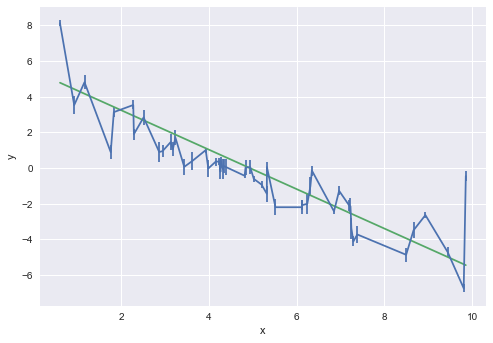

In [33]:
x_data = np.linspace(0, 10, 100)
plt.errorbar(x, y, yerr = yerror) # Graficamos los datos
plt.plot(data[0], line(min_sol.x[0],min_sol.x[1],data[0])) #Graficamos la línea recta con estos parámetros
plt.xlabel('x')
plt.ylabel('y')

El valor real es $m = -0.95$ y $b = 4.29$. Así que en $m$ es muy aproximado, pero en $b$ se aleja un poco.

----------------------------

### **Ajuste con tres parámetros.**

**El modelo es el mismo pero $\chi^2$ cambia. $\chi^2 = (y_i-y_m)^2/(\Delta\sigma^2) + \ln \sigma^2$ donde $\sigma^2 = \sigma^2 + (f*y_m)^2$**

In [44]:
def line(m, b,x):
    return m*x + b # Linea recta

def chisq(theta, data):
    m = theta[0] # Primer parámetro
    b = theta[1] # Segundo parámetro
    f = np.exp(2*theta[2]) # Tercer parámetro
    model = line(m,b,data[0])
    sigma2 = (data[2]**2+(f*model)**2)
    chisq = (data[1]-model)**2/sigma2 + np.log(sigma2) # Función chi_square
    return chisq.sum()

Vemos si chisq funciona:

In [45]:
chisq([-1,4,np.log(0.1)], data)

1696.892223334976

Utilizamos minimize.

In [46]:
ini_point = (-2,4,0.1) # Punto inicial

min_sol = op.minimize(chisq, ini_point, args = data, method = 'L-BFGS-B', bounds=((-10,10),(0,10),(-6,1)))

Vemos las soluciones:

In [47]:
min_sol

      fun: 24.364827896138998
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.41060513e-04, 1.28608235e-04, 9.98312544e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 120
      nit: 15
   status: 0
  success: True
        x: array([-1.00300921,  4.52831764, -0.39522036])

Ahora graficamos:

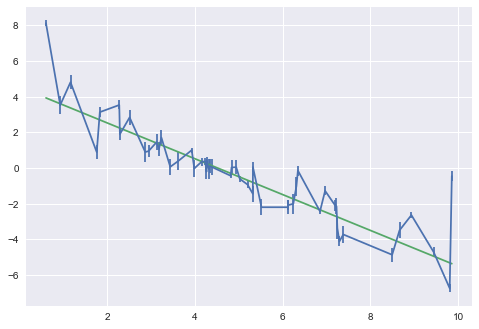

In [48]:
plt.errorbar(x, y, yerr = yerror)
plt.plot(data[0], line(min_sol.x[0], min_sol.x[1], data[0]))

Podemos ver que éste es un mejor ajuste, ya que $m$ y $b$ son valores muy reales.

-----------------------------------------------

### **Ahora con PowerSpectrum**

Importamos la librería colossus.

In [65]:
from colossus.cosmology import cosmology

In [66]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


Descargamos los datos:

In [67]:
pk_cmasdr12 = np.loadtxt('GilMarin_2016_CMASSDR12_measurement_monopole_post_recon.txt').T

Definimos nuestro modelo, el cual es $P_k = b^2(1+\beta)P_l$ y $\chi^2$.

In [68]:
def Pk_Om(Om_,b,beta,k):
    cosmo = cosmology.setCosmology('planck15') # Generamos los parámetros default del experimento planck15
    z = 0.57 
    cosmo.Om0 = Om_ # Modificamos la densidad de materia
    return b**2*(1+beta)*cosmo.matterPowerSpectrum(k,z) # Se regresa la función matterPowerSpectrum multiplicada por el bias al cuadrado

In [69]:
def chisq(theta,data): # Función que calcula el logaritmo natural del likelihood
    Om = theta[0]
    b = theta[1]
    beta = theta[2]
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    yerr = data[2]  # Llamamos yerror al tercer conjunto de datos
    model = Pk_Om(Om, b, beta,equis) # Calculamos el modelo utilizando la función Pk_om
    chisq2 = (ye-model)**2/(yerr**2) #+ np.log(yerr**2) # Obtenemos chi^2
    return chisq2.sum() # Regresamos la suma de todos los chi^2, que da como resultado el ln del likelihood.

Vemos si chisq funciona:

In [70]:
chisq([0.3,1,np.log(0.1)], data)

431414.72406718036

Damos un punto inicial y utilizamos minimize de scipy.

In [71]:
ini_point = (0.3,1.6,0.1)

#chisq_ = lambda *args: chisq(*args)
data = pk_cmasdr12

min_sol = op.minimize(chisq, ini_point, args = data, method = 'L-BFGS-B', bounds=((0,1),(0,5),(0,1)))

In [72]:
min_sol

      fun: 1516.6063938834045
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  3.86535248e-04, -9.09494702e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 32
      nit: 5
   status: 0
  success: True
        x: array([0.3       , 1.9145828 , 0.18428751])

**Ahora el objetivo es utilizar las soluciones de minimize de scipy para empezar ahí nuestros caminadores cuando implementemos nuestro código de metrópolis.**

Metrópolis:

In [74]:
np.random.seed(1) # Semilla para los números aleatorios.
x = pk_cmasdr12[0][15:45] # Quitamos los datos del inicio que no se ajustan a ningún modelo del matterPowerSpectrum
y = pk_cmasdr12[1][15:45]
yerror = pk_cmasdr12[2][15:45]

Om_total = [] # Declaramos Om_total, que es donde se guardarán los valores de Om0 para cada camino
b_total = [] # Lo mismo para el bias. 
beta_total = []

sigma = 0.01 # Desviación estándar de la distribución gaussiana de números aleatorios.
rango = 2500

for k in range(10): # 5 caminos
    Om_0 = np.random.normal(min_sol.x[0], 0.10, 10) # Los valores iniciales para cada camino se generarán con las soluciones de de minimize.
    b0 = np.random.normal(min_sol.x[1], 0.28, 10) # Lo mismo para el bias
    beta0 = np.random.uniform(min_sol.x[2], 0.10, 10) # Lo mismo para beta
    Om_sample = [Om_0[k]] # Guardamos el valor inicial para Om0 del camino k
    b_sample = [b0[k]] # Guardamos el valor inicial para el bias del camino k
    beta_sample = [beta0[k]] # Guardamos el valor inicial para el Beta del camino k
    lnlike0 = -1*chisq([Om_0[k], b0[k], beta0[k]],[x,y,yerror]) # Calculamos el logaritmo natural del likelihood inicial para cada camino
    for j in range(1,rango):
        Om_new = np.random.normal(Om_sample[len(Om_sample)-1], sigma) # Obtenemos un nuevo valor para Om0
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma) # Obtenemos un nuevo valor para b
        beta_new = np.random.normal(beta_sample[len(beta_sample)-1], sigma) # Obtenemos un nuevo valor para beta
        if Om_new <= 0.8 and Om_new >= 0.1 and b_new <= 3.0 and b_new >= 1.0 and beta_new >= 0 and beta_new <=0.7: # Prior
            like = -1*chisq([Om_new, b_new, beta_new],[x,y,yerror]) # Prior
            if like>lnlike0: # Si el nuevo ln de L es mayor que el anterior, se acepta
                lnlike0 = like
                Om_sample.append(Om_new) # Se guarda el nuevo valor de Om0 para el camino k
                b_sample.append(b_new) # Lo mismo para b
                beta_sample.append(beta_new)
            elif lnlike0-like<-math.log(random.uniform(0,1)): # Si la diferencia es menor que el logaritmo de un número aleatorio en 0 y 1 se acepta
                lnlike0 = like 
                Om_sample.append(Om_new) # Se guarda el nuevo valor de Om0 para el camino k
                b_sample.append(b_new) # Lo mismo para b
                beta_sample.append(beta_new)
    Om_total.append(Om_sample) # Se guardan los valores de Om0 del camino k en m_total
    b_total.append(b_sample)
    beta_total.append(beta_sample)

Text(0.5, 0, '$beta$')

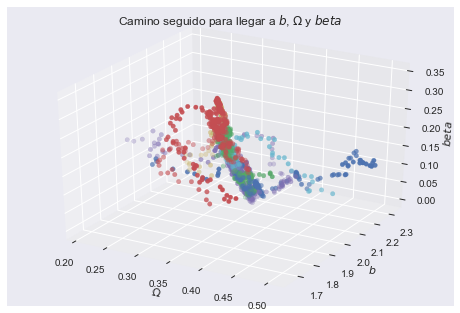

In [75]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')

for i in range(len(Om_total)):
    ax1.scatter(Om_total[i], b_total[i], beta_total[i])


ax1.set_title('Camino seguido para llegar a $b$, $\Omega$ y $beta$')
ax1.set_xlabel('$\Omega$')
ax1.set_ylabel('$b$')
ax1.set_zlabel('$beta$')

In [79]:
Om_new = []
b_new = []
beta_new = []

burn = 10
for i in range(len(Om_total)):
    if(len(Om_total[i])>burn and len(b_total[i])>burn and len(beta_total[i])):
        Om_new.append(Om_total[i][burn:])
        b_new.append(b_total[i][burn:])
        beta_new.append(beta_total[i][burn:])

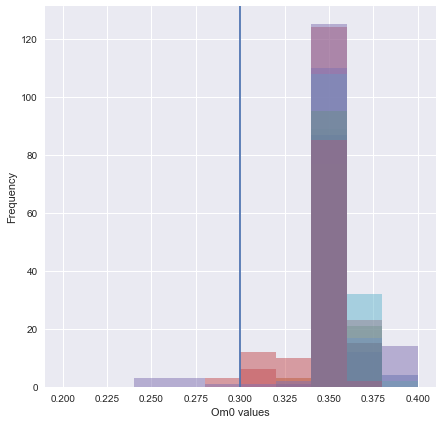

In [86]:
plt.figure(figsize = (7,7))
for i in range(len(Om_new)):
    plt.hist(Om_new[i], range = (0.2,0.4),alpha = 0.5)

plt.axvline(min_sol.x[0])
plt.xlabel('Om0 values')
plt.ylabel('Frequency');

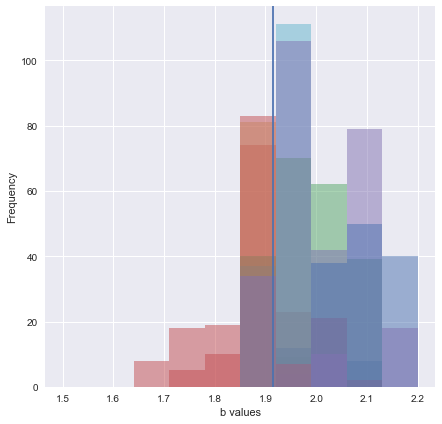

In [85]:
plt.figure(figsize = (7,7))
for i in range(len(b_new)):
    plt.hist(b_new[i], range = (1.5,2.2),alpha = 0.5)

plt.axvline(min_sol.x[1])
plt.xlabel('b values')
plt.ylabel('Frequency');

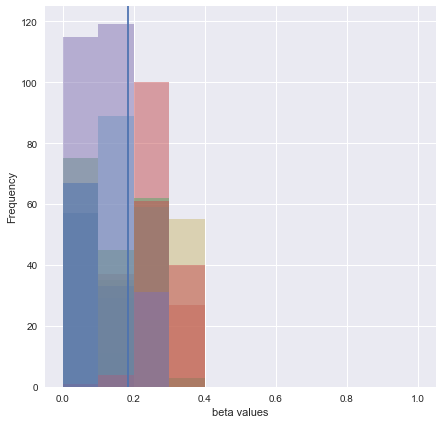

In [83]:
plt.figure(figsize = (7,7))
for i in range(len(beta_new)):
    plt.hist(beta_new[i], range = (0.0,1.0),alpha = 0.5)

plt.axvline(min_sol.x[2])
plt.xlabel('beta values')
plt.ylabel('Frequency');

Usamos el método de Gelman-Rubin para determinar si las cadenas han convergido. Referencia: https://arxiv.org/pdf/1812.09384.pdf

In [87]:
n = 10 # Número de caminos

def prom_x_i(x_it):
    return np.mean(x_it) # Promedio de un camino

def prom_mu(x_i):
    sum = 0
    for i in range(n):
        sum = sum + prom_x_i(x_i[i]) # Promedio de todos los caminos
    return sum/n

def s_i2(x_it):
    return np.std(x_it) # Desviación estándar de un camino

def s2(x_i):
    sum = 0
    for i in range(n):
        sum = sum + s_i2(x_i[i]) # Desviación estándar de todos los caminos
    return sum/n

def B_n(x_i): # Parámetro Bn
    sum = 0
    for i in range(n):
        sum = sum + (prom_x_i(x_i[i])-prom_mu(x_i))**2
    return sum/(n-1)

def sigma_gorro2(x_i, m):  
    return (m-1)*s2(x_i)/m + B_n(x_i)

def R(x_i, m): # Parámetro R
    return math.sqrt(sigma_gorro2(x_i, m)/s2(x_i))

In [88]:
len(Om_new)

10

In [89]:
n = len(Om_new)
R(Om_new, len(Om_new[0]))

1.0006377626179928

In [90]:
R(b_new, len(b_new[0]))

1.1134201590272097

In [91]:
R(beta_new, len(b_new[0]))

1.095776150804751

NOTA: Estos valores para R son mucho mejores que en códigos anteriores.

**Ahora calculamos las medianas.**

In [93]:
from statistics import median

In [94]:
mediana0 = []

for i in range(len(Om_new)):
    mediana0.append(np.median(Om_new[i]))

In [95]:
medianab = []

for i in range(len(b_new)):
    medianab.append(np.median(b_new[i]))

In [96]:
medianabeta = []

for i in range(len(beta_new)):
    medianabeta.append(np.median(beta_new[i]))

In [97]:
Om0 = median(mediana0)
be = median(medianab)
beta = median(medianabeta)
print(Om0, be, beta)

0.35544653461206976 1.9451868846868956 0.17996980673175028


**Vemos cómo nuestros caminos convergen al mismo valor:**

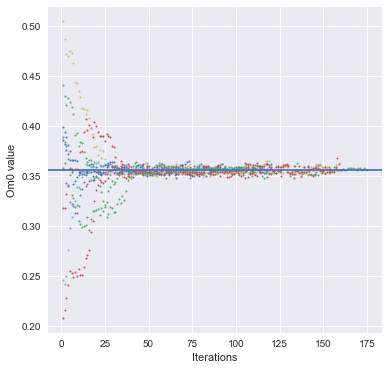

In [102]:
plt.figure(figsize = (6,6))

for i in range(1,len(Om_total)):
    iteraciones = np.linspace(1, len(Om_total[i]), len(Om_total[i]))
    plt.plot(iteraciones, Om_total[i], 'o', markersize = 2)


plt.grid('True')
plt.xlabel('Iterations')
plt.axhline(Om0)
plt.ylabel('Om0 value');

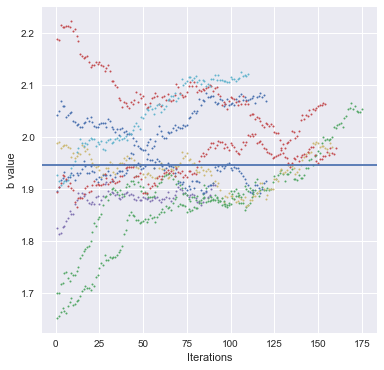

In [99]:
plt.figure(figsize = (6,6))

for i in range(1,len(b_total)):
    iteraciones = np.linspace(1, len(b_total[i]), len(b_total[i]))
    plt.plot(iteraciones, b_total[i], 'o', markersize = 2)


plt.grid('True')
plt.xlabel('Iterations')
plt.axhline(be)
plt.ylabel('b value');

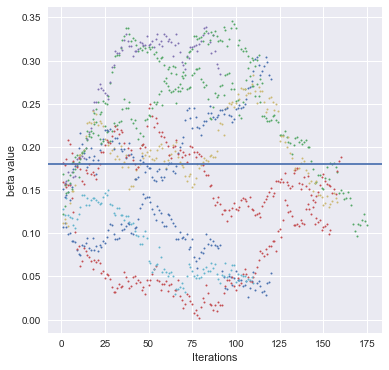

In [100]:
plt.figure(figsize = (6,6))

for i in range(1,len(beta_total)):
    iteraciones = np.linspace(1, len(beta_total[i]), len(beta_total[i]))
    plt.plot(iteraciones, beta_total[i], 'o', markersize = 2)


plt.grid('True')
plt.xlabel('Iterations')
plt.axhline(beta)
plt.ylabel('beta value');

**Finalmente graficamos y vemos qué tan bien nuestro modelo se ajusta a los datos**

Text(0, 0.5, 'P(k)')

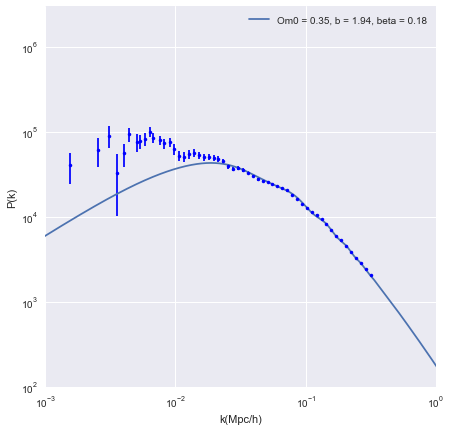

In [104]:
plt.figure(figsize = (7,7))
plt.loglog()

k = 10**np.linspace(-5,6,100000)
cosmo.Om0 = Om0
Pk = be**2*(1+beta)*cosmo.matterPowerSpectrum(k,0.57)

plt.plot(k,Pk, '-', label = 'Om0 = 0.35, b = 1.94, beta = 0.18') # Con bias
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.b')
  
plt.xlim(1e-3,1)
plt.ylim(100,3e6)
plt.legend()
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')

---------------------------------

## Utilizando emcee

In [49]:
import emcee
import tqdm

In [50]:
def Pk_Om(Om_,b,beta,k):
    cosmo = cosmology.setCosmology('planck15') # Generamos los parámetros default del experimento planck15
    z = 0.57 
    cosmo.Om0 = Om_ # Modificamos la densidad de materia
    return b**2*(1+beta)*cosmo.matterPowerSpectrum(k,z) # Se regresa la función matterPowerSpectrum multiplicada por el bias al cuadrado

In [56]:
def log_likelihood(theta,data): # Función que calcula el logaritmo natural del likelihood
    Om = theta[0]
    b = theta[1]
    beta = theta[2]
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    yerr = data[2]  # Llamamos yerror al tercer conjunto de datos
    model = Pk_Om(Om, b, beta,equis) # Calculamos el modelo utilizando la función Pk_om
    chisq2 = (ye-model)**2/(yerr**2) + np.log(yerr**2) # Obtenemos chi^2
    return chisq2.sum() # Regresamos la suma de todos los chi^2, que da como resultado el ln del likelihood.

In [57]:
log_likelihood([0.4, 2, 1.6], data)

407868.7905089504

In [58]:
np.random.seed(42)

In [59]:
ini_point = (0.3,1.6,0.1)

#chisq_ = lambda *args: chisq(*args)
data = pk_cmasdr12

min_sol = op.minimize(log_likelihood, ini_point, args = data, method = 'L-BFGS-B', bounds=((0,1),(0,5),(0,1)))

In [60]:
min_sol

      fun: 2292.920841719627
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  5.45696821e-04, -4.54747351e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 32
      nit: 5
   status: 0
  success: True
        x: array([0.3       , 1.9145828 , 0.18428751])

In [77]:
def log_prior(theta):
    Om0, b, beta = theta
    if 0.05 < Om0 < 0.8 and 0.1 < b < 3 and 0.05 < beta < 0.8:
        return 0.0
    return -np.inf

In [78]:
x, y, yerr = pk_cmasdr12[0], pk_cmasdr12[1], pk_cmasdr12[2]
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + -0.5*log_likelihood(theta, [x, y, yerr])

In [79]:
pos = min_sol.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

C:\Users\Gab\Anaconda3\lib\site-packages\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:04<00:00, 10.32it/s]


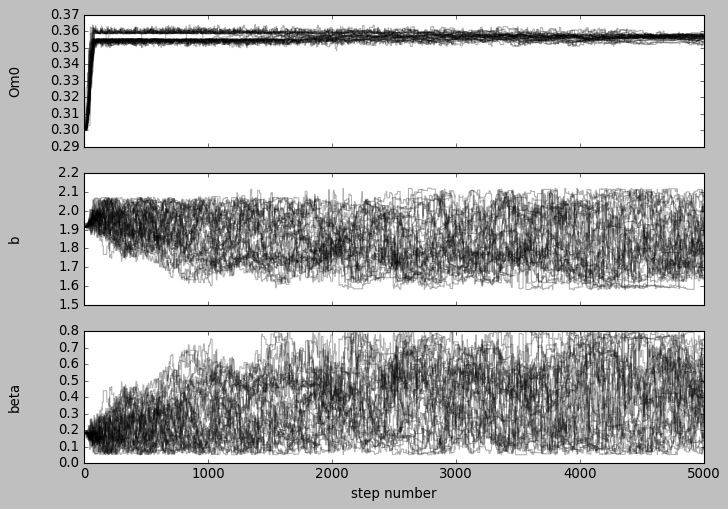

In [80]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Om0", "b", "beta"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

In [81]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


<function matplotlib.pyplot.show(*args, **kw)>

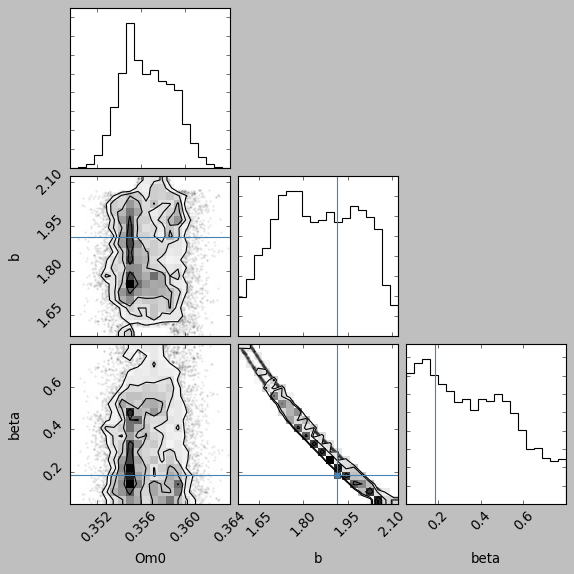

In [82]:
import corner
plt.style.use('classic')
fig = corner.corner(
    flat_samples, labels=labels, truths=min_sol.x
);
plt.show

In [83]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0, 0.5, 'P(k)')

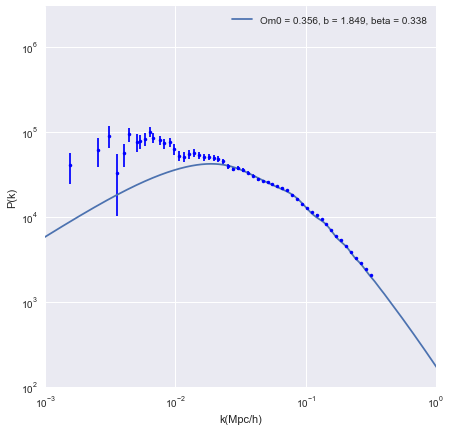

In [106]:
plt.figure(figsize = (7,7))
plt.loglog()

k = 10**np.linspace(-5,6,100000)
cosmo.Om0 = 0.356
Pk = 1.849**2*(1+0.338)*cosmo.matterPowerSpectrum(k,0.57)

plt.plot(k,Pk, '-', label = 'Om0 = 0.356, b = 1.849, beta = 0.338') # Con bias
plt.errorbar(pk_cmasdr12[0], pk_cmasdr12[1], yerr = pk_cmasdr12[2], fmt = '.b')
  
plt.xlim(1e-3,1)
plt.ylim(100,3e6)
plt.legend()
plt.xlabel('k(Mpc/h)')
plt.ylabel('P(k)')